In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import clip
import re
import time
import yaml
import os
from matplotlib import pyplot as plt
import pandas as pd
from sentence_transformers import SentenceTransformer
from networks import SCLIPNN, SCLIPNN3
from utils import EmbeddingsDataset, get_models_to_train

In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model, preprocess = clip.load("ViT-B/32", device=device)
clip_model.eval()
sbert_model = SentenceTransformer('all-MiniLM-L6-v2')
sbert_model.eval()
bertin_model = SentenceTransformer('hackathon-pln-es/bertin-roberta-base-finetuning-esnli')
bertin_model.eval()
print("Models: CLIP, SBERT, BERTIN")

Models: CLIP, SBERT, BERTIN


In [12]:
with open("config.yml", "r") as ymlfile:
    cfg = yaml.safe_load(ymlfile)
params = cfg["training"]

In [13]:
def get_files_paths(directory):
    train_txt = 'train_sentences.txt'    
    valid_txt = 'valid_sentences.txt'
    train_path = os.path.join(directory,train_txt)    
    valid_path = os.path.join(directory,valid_txt)
    return train_path, valid_path
    
def get_sentences_from_file(filename):
    sentences = []
    with open(filename, mode='rt', encoding='utf-8') as file_object:
        for line in file_object:
            sentences.append(line)    
    return sentences

def regexification(sentences):
    sentences = list(map(lambda s: s.replace('á','a').replace('ó','o').replace('é','e').replace('í','i').replace('ú','u').replace('ñ','n'), sentences))
    regex = [r"[^A-Za-z0-9]+|[a-zA-Z][0-9]", r"(?<!\d)[0]\d*(?!\d)", r"\s+", r"[0-9]+"]
    for r in regex:        
        sentences = list(map(lambda sentence: re.sub(r, " ", sentence), sentences))
    return sentences

def get_clip_embeddings(sentences):
    tokenized_text = clip.tokenize(sentences).to(device)
    with torch.no_grad():
        clip_embeddings = clip_model.encode_text(tokenized_text)
        clip_embeddings.to('cpu')
    return clip_embeddings

def get_sbert_embeddings(sentences):
    with torch.no_grad():  
        sbert_embeddings = torch.from_numpy(sbert_model.encode(sentences))
    return sbert_embeddings

def get_bertin_embeddings(sentences):
    with torch.no_grad():  
        bertin_embeddings = torch.from_numpy(bertin_model.encode(sentences))
    return bertin_embeddings

def show_embeddings_return_size(sentences, clip_emb, sbert_emb, bertin_emb):
    ("-"*10)
    for sentence, cl, sb, be in zip(sentences[:1], clip_emb[:1], sbert_emb[:1], bertin_emb[:1]):
        print("Sentence:", sentence)
        sb_size = sb.size()[0]    
        print("Sbert Embedding: ", sb_size)
        cl_size = sb_emb.size()[0]
        print("Clip Embedding: ", cl_size)
        be_size = be_emb.size()[0]
        print("Clip Embedding: ", be_size)
        print("-"*10)
    return sb_size, cl_size, be_size

In [31]:
def get_train_embeddings(directory,transformer = 'sbert'):
    train_file, valid_file = get_files_paths(directory)
    train_sentences = regexification(get_sentences_from_file(train_file))
    valid_sentences = regexification(get_sentences_from_file(valid_file))
    print("CLIP encoding...")    
    train_clip_embeddings = get_clip_embeddings(train_sentences)
    valid_clip_embeddings = get_clip_embeddings(valid_sentences)
    if transformer == 'sbert':
        print("SBERT encoding...")
        train_embeddings = get_sbert_embeddings(train_sentences)
        valid_embeddings = get_sbert_embeddings(valid_sentences)
    elif transformer == 'bertin':
        print("BERTIN encoding...")
        train_sentences = get_sentences_from_file(train_file)
        valid_sentences = get_sentences_from_file(valid_file)
        train_embeddings = get_bertin_embeddings(train_sentences)
        valid_embeddings = get_bertin_embeddings(valid_sentences)
    else:
        print("Given transformer is not valid")
    return train_clip_embeddings, valid_clip_embeddings, train_embeddings, valid_embeddings

In [14]:
def show_plot(models,model_train_losses,model_valid_losses):
    rows = 2
    columns = int((len(models)+1)/2)
    fig, axs = plt.subplots(rows,columns,figsize=(18,10))
    positions = []
    for r in range(rows):
        for c in range(columns):
            positions.append((r,c))
    for i, (name, model) in enumerate(models.items()):
        axs[positions[i]].plot(model_train_losses[i][1:], label = 'train '+ name)
        axs[positions[i]].plot(model_valid_losses[i][1:], label = 'valid '+ name, marker = '*')
        axs[positions[i]].set_title('Losses of '+ name)
        axs[positions[i]].grid()
        axs[positions[i]].legend()
    
    for ax in axs.flat:
        ax.set(xlabel='Epochs', ylabel='Loss')
    
    plt.show()

In [15]:
def train(model, train_dataset, valid_dataset, b_size=32, epochs=params["epochs"], print_every=params["print_every"]):
    criterion = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)    
    train_losses = []
    valid_losses = []
    for epoch in range(epochs):  # loop over the dataset multiple times
        train_loss = 0.0
        model.train()
        train_loader = DataLoader(train_dataset, batch_size=b_size, shuffle=True)
        valid_loader = DataLoader(valid_dataset, batch_size=b_size, shuffle=True)
        train_counter = 0
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)            
            optimizer.zero_grad()
            output = model(inputs)
            loss = criterion(output.to(float), labels.to(float))       
            loss.backward()
            optimizer.step()
            inputs.to('cpu')
            labels.to('cpu')
            train_loss += loss.item()         
            train_counter += 1
        train_losses.append(train_loss/train_counter)
        
        valid_loss = 0.0
        model.eval()
        valid_counter = 0
        for inputs, labels in valid_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            target = model(inputs)
            loss = criterion(target.to(float), labels.to(float))
            valid_loss += loss.item()
            valid_counter += 1
            inputs.to('cpu')
            labels.to('cpu')
        valid_losses.append(valid_loss/valid_counter)
        if (epoch % print_every == 0) or (epoch == epochs - 1):
            print("Epoch {}. Train Loss: {}. Valid Loss: {}".format(epoch, train_loss/train_counter, valid_loss/valid_counter))
    return train_losses, valid_losses

In [39]:
def supra_training(models,train_emb,train_clip_emb,valid_emb, valid_clip_emb, trainset,transformer = 'sbert'):
    model_train_losses = []
    model_valid_losses = []
    final_loss = []
    training_time = []
    for name, model in models.items():
        start_time = time.time()
        train_dataset = EmbeddingsDataset(train_emb, train_clip_emb)
        valid_dataset = EmbeddingsDataset(valid_emb, valid_clip_emb)
        train_loss, valid_loss = train(model, train_dataset, valid_dataset)
        torch.save(model.state_dict(), os.path.join('models',trans + '_' + trainset + '_' + name + '.pt'))
        model_train_losses.append(train_loss)                   
        model_valid_losses.append(valid_loss)
        final_loss.append(round(valid_loss[-1],3))
        end_time = time.gmtime(time.time() - start_time)
        elapsed_time = time.strftime("%H:%M:%S", end_time)
        training_time.append(elapsed_time)
        print('Finished Training from model {}. Elapsed time: {}.'.format(name,elapsed_time))
        #print("-"*50)        
    actual_time = time.strftime("%Y/%m/%d, %H:%M:%S", time.gmtime(time.time()))
    print("End of Training Process on {}".format(actual_time))
    return model_train_losses, model_valid_losses, training_time, final_loss

CLIP encoding...
BERTIN encoding...
Creating Models to train...
4 models created.
Training on europarl_es dataset
Epoch 0. Train Loss: 0.2497898362560362. Valid Loss: 0.22811412470086062
Epoch 50. Train Loss: 0.032506694040384455. Valid Loss: 0.055952044596770965
Epoch 100. Train Loss: 0.02667331310100575. Valid Loss: 0.04788964551719639
Epoch 149. Train Loss: 0.023653610055784268. Valid Loss: 0.04400126900630064
Finished Training from model NN_700. Elapsed time: 00:00:32.
Epoch 0. Train Loss: 0.2251930320560608. Valid Loss: 0.2157424018899706
Epoch 50. Train Loss: 0.029507724352499674. Valid Loss: 0.042203970050101944
Epoch 100. Train Loss: 0.024370104175116897. Valid Loss: 0.036531256343397725
Epoch 149. Train Loss: 0.02238170521965906. Valid Loss: 0.033956710633023246
Finished Training from model NN3_700. Elapsed time: 00:00:37.
Epoch 0. Train Loss: 0.24338356448735374. Valid Loss: 0.2203271974188122
Epoch 50. Train Loss: 0.031569662544282645. Valid Loss: 0.054604147647529404
Epoch 

,TrainLoss,ValidLoss
NN_700,0.023654,0.044
NN3_700,0.022382,0.034
NN_800,0.022917,0.043
NN3_800,0.022002,0.034


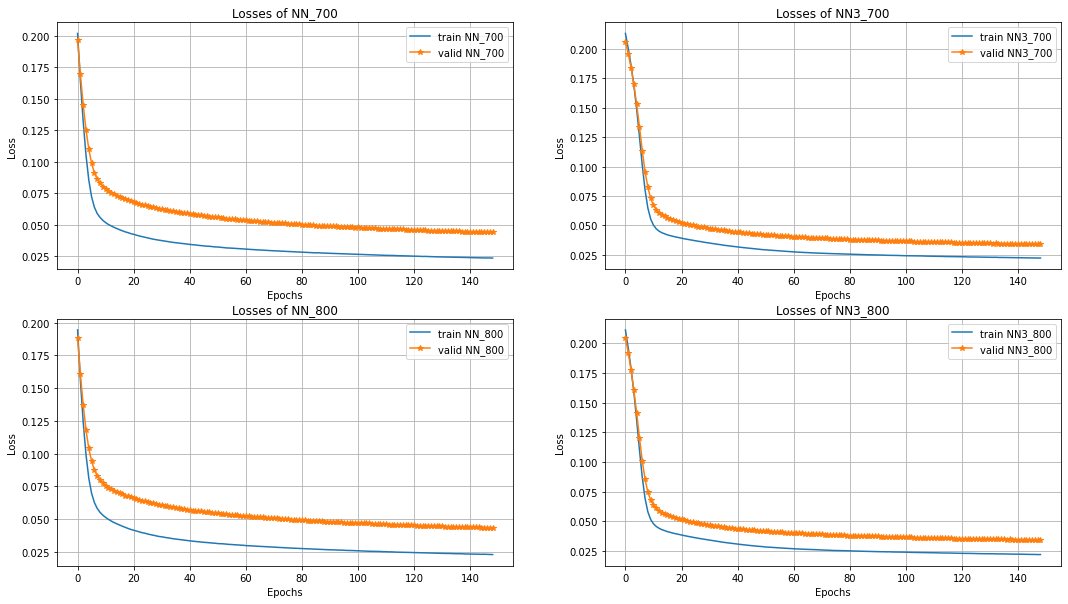

In [40]:
### Training Pipeline
durations = {}
finals = {}
model_dict = {}
directory = 'europarl_es'
trans = 'bertin'
train_clip_emb, valid_clip_emb, train_emb, valid_emb = get_train_embeddings(directory, transformer=trans)
input_size = train_emb[0].size()[0]
model_dict[directory] = get_models_to_train(input_size)
print(f'Training on {directory} dataset')
train_losses, valid_losses, train_time,final_loss = supra_training(model_dict[directory],train_emb,train_clip_emb, valid_emb, valid_clip_emb,trainset=directory,transformer=trans)
durations[directory] = train_time
finals[directory] = final_loss
train_final_losses = [x[-1] for x in train_losses]
train_results = pd.DataFrame({"TrainLoss":train_final_losses, "ValidLoss":final_loss}, index=model_dict[directory].keys())
display(train_results)
show_plot(model_dict[directory],train_losses,valid_losses)